# SKOL IV: All the Data

Synoptic Key of Life (SKOL) is a web site and application that aims to provide easy access to all of the open taxonomic literature in Mycology. A synoptic key is a tool that helps you identify an organism making successive observations, building up a detailed description of the organism in front of you. There are many fine synoptic keys available for particular taxa, but they are all hand-built. SKOL uses AI to build the synoptic key automatically.

The goal is to make it easier for advanced amateur mycologists to build technical descriptions of fungi.''

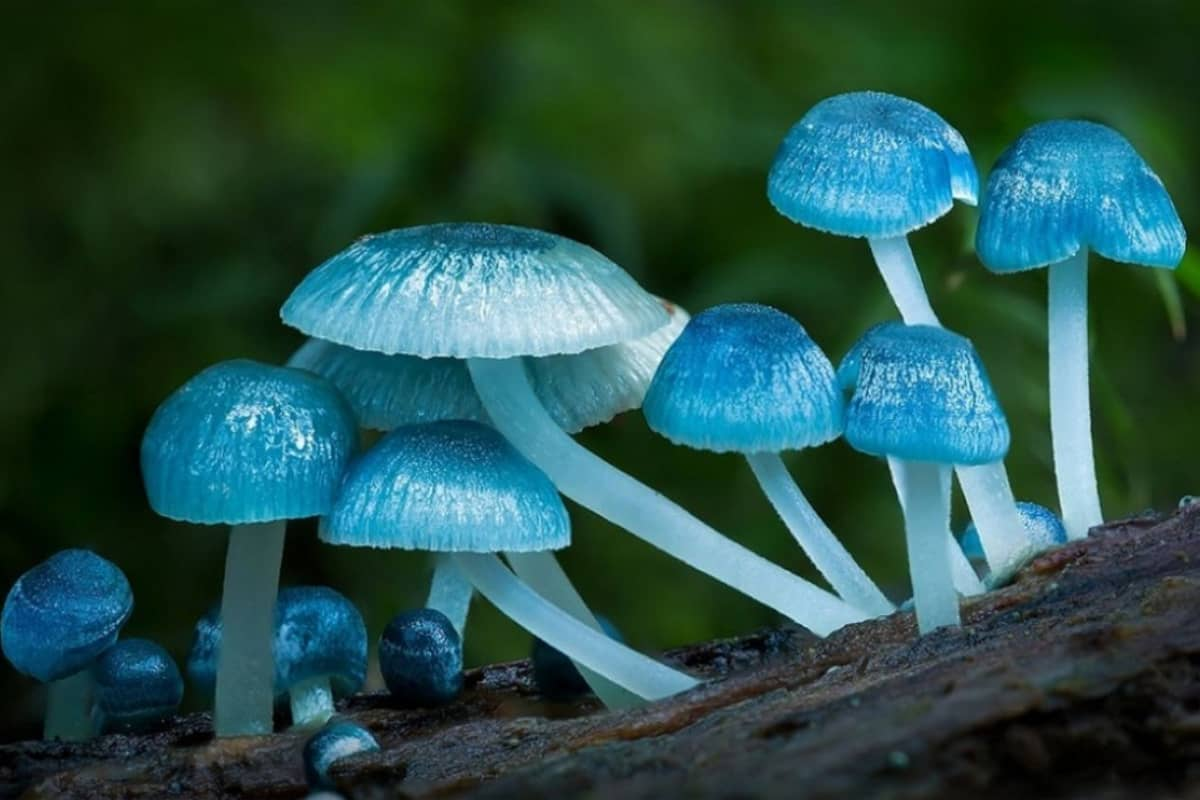 Credit: Garth Smith Photography 2018.

## Storage needs

SKOL uses a diverse set of databases to hold different artifacts.

The original literature is ingested into the document database CouchDB (citation needed) along with available publication metadata. The originals are typically PDF files which are stored as attachments on the CouchDB ingestion records.

Text is extracted from the ingested files, using OCR if necessary. This text is a second attachment on the ingestion record.

A classifier is trained from hand-annotated articles and stored in Redis. The model has an expiration period of several weeks. The classifier then annotates each text document with labels for Nomenclature, Description, and Misc-exposition. It stores these annotated articles as attachments on the CouchDB ingestion records.

Taxon names (typically species names with literature annotation) and combined with matching descriptions into Taxon records and stored in another CouchDB database. These records are the core data for SKOL.

The Taxon records are processed a number of ways: sentence embedding, JSON encoding, and artificial cladograms.

The sentence embedding is done with an SBERT model (citation needed) and stored as a blob in Redis. The embedding has an expiration period of 24 hours.

A Mistral model (citation needed) converts each Taxon record description is converted into a hierarchy of features, subfeatures, and values. The epectation is that these data structures will eventually form the basis of pull-down menus in the SKOL user interface. These JSON structures are stored in another CouchDB database.

The sentence embeddings are further processed into a single tree of Taxon reccords based on their distance from each other in the sentence embedding space. This tree is stored in a neo4j database.

## A note on source code

In order to include only the most relevant parts of the source code, the heavy lifting of the new classes is not shown. Only the storage related methods are exposed here.


In [1]:
bahir_package = 'org.apache.bahir:spark-sql-cloudant_2.12:2.4.0'
!spark-shell --packages $bahir_package < /dev/null

25/12/20 20:24:02 WARN Utils: Your hostname, puchpuchobs resolves to a loopback address: 127.0.1.1; using 10.1.10.58 instead (on interface wlp130s0f0)
25/12/20 20:24:02 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
:: loading settings :: url = jar:file:/data/piggy/miniconda3/envs/skol/lib/python3.13/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /home/piggy/.ivy2/cache
The jars for the packages stored in: /home/piggy/.ivy2/jars
org.apache.bahir#spark-sql-cloudant_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-c2321fa6-bf79-4172-8e20-2240485cb895;1.0
	confs: [default]
	found org.apache.bahir#spark-sql-cloudant_2.12;2.4.0 in central
	found org.apache.bahir#bahir-common_2.12;2.4.0 in central
	found org.spark-project.spark#unused;1.0.0 in central
	found com.cloudant#cloudant-client;2.17.0 in central
	found com.google.code.gson#gson;2.8.2 in central
	found 

In [2]:
import os
# Forces synchronous execution, making it easier to track GPU operations.
os.environ['CUDA_LAUNCH_BLOCKING'] = '1' 

# Enables basic CUDA debug logging.
os.environ['CUDA_DEBUG'] = '1' 

# Other potentially useful variables for more detailed logging:
# os.environ['CUDA_API_CALLS'] = '1' # Logs CUDA API calls
os.environ['CUDA_LOG_LEVEL'] = 'DEBUG' # Or 'DEBUG', 'WARNING', etc.


In [3]:
from io import BytesIO
import json
import hashlib
import os
from pathlib import Path, PurePath
import pickle
import requests
import shutil
import sys
import tempfile
import time
from typing import Any, Dict, Iterator, List, Optional, Tuple
from urllib.robotparser import RobotFileParser
import warnings

warnings.filterwarnings('error', category=UserWarning)

# os.environ['LD_LIBRARY_PATH'] = '/data/piggy/miniconda3/envs/skol/lib/python3.13/site-packages/nvidia/cusparselt/lib'

# Be sure to get version 2: https://simple-repository.app.cern.ch/project/bibtexparser/2.0.0b8/description
import bibtexparser
import couchdb
import feedparser
import fitz # PyMuPDF

import pandas as pd  # TODO(piggy): Remove this dependency in favor of pure pyspark DataFrames.

from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import (
    Tokenizer, CountVectorizer, IDF, StringIndexer, VectorAssembler, IndexToString
)
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier

from pyspark.sql import SparkSession, DataFrame, Row
from pyspark.sql.functions import (
    input_file_name, collect_list, regexp_extract, col, udf,
    explode, trim, row_number, min, expr, concat, lit
)
from pyspark.sql.types import (
    ArrayType, BooleanType, IntegerType, MapType, NullType,
    StringType, StructType, StructField
)
from pyspark.sql.window import Window

import redis
from uuid import uuid4

# Local modules
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
parent_path = Path(parent_dir)
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# TODO: Make a TaxonExtractor in this notebook with the needed i/o functions.
from fileobj import FileObject
from finder import parse_annotated, remove_interstitials
import line
from line import Line

import numpy as np

# Import SKOL classifiers
from skol_classifier.model import SkolModel
from skol_classifier.output_formatters import YeddaFormatter
from skol_classifier.preprocessing import SuffixTransformer, ParagraphExtractor
from skol_classifier.utils import get_file_list

from taxon import group_paragraphs, Taxon


## Important constants

In [4]:
should_ingest = False  # Should we ingest from the real web sites?
run_ocr = False  # Should we extract text from PDFs?
model_to_use = "rnn"
create_classifier = True  # Should we recalculate the classifier?
add_annotations = True # Should we add *.ann files? Very expensive!
build_taxon = True
generate_json = True  # Run mistral to generate JSON descriptions?
compute_embeddings = True  # Compute embeddings and save them.
run_clustering = True  # Produce the neo4j database.

couchdb_host = "127.0.0.1:5984" # e.g., "ACCOUNT.cloudant.com" or "localhost"
couchdb_username = "admin"
couchdb_password = "SU2orange!"
ingest_db_name = "skol_dev"  # Development ingestion database
taxon_db_name = "skol_taxa_dev"  # Development Taxa database
json_taxon_db_name = "skol_taxa_full_dev"  # Development Taxa database with JSON translations

redis_host = 'localhost'
redis_port = 6379

embedding_name = 'skol:embedding:v1.1'
embedding_expire = 60 * 60 * 24 * 2  # Expire after 2 days.
classifier_model_expire = 60 * 60 * 24  * 2 # Expire after 2 days.
model_version = "v2.0"
neo4j_uri = "bolt://localhost:7687"

couchdb_url = f'http://{couchdb_host}'

cores = 2

## robots.txt

We want to be a well-behaved web scraper. Respect `robots.txt`, a standardized file that tells us what parts of a web site a scraper is allowed to access.

In [5]:
user_agent = "synoptickeyof.life"

ingenta_rp = RobotFileParser()
ingenta_rp.set_url("https://www.ingentaconnect.com/robots.txt")
ingenta_rp.read() # Reads and parses the robots.txt file from the URL

## Spark, couchdb, and redis connections

In [6]:
def make_spark_session():
    time.sleep(2)

    retval = SparkSession \
        .builder \
        .appName("CouchDB Spark SQL Example in Python using dataframes") \
        .master(f"local[{cores}]") \
        .config("cloudant.protocol", "http") \
        .config("cloudant.host", couchdb_host) \
        .config("cloudant.username", couchdb_username) \
        .config("cloudant.password", couchdb_password) \
        .config("spark.jars.packages", bahir_package) \
        .config("spark.driver.memory", "16g") \
        .config("spark.executor.memory", "20g") \
        .config("spark.driver.extraJavaOptions",
                "--add-opens=java.base/java.nio=ALL-UNNAMED "
                "--add-opens=java.base/sun.nio.ch=ALL-UNNAMED "
                "--add-opens=java.base/sun.security.action=ALL-UNNAMED "
                "--add-opens=java.base/sun.util.calendar=ALL-UNNAMED") \
        .config("spark.executor.extraJavaOptions",
                "--add-opens=java.base/java.nio=ALL-UNNAMED "
                "--add-opens=java.base/sun.nio.ch=ALL-UNNAMED "
                "--add-opens=java.base/sun.security.action=ALL-UNNAMED "
                "--add-opens=java.base/sun.util.calendar=ALL-UNNAMED") \
        .config("spark.submit.pyFiles",
                f'{parent_path / "line.py"},{parent_path / "fileobj.py"},'
                f'{parent_path / "couchdb_file.py"},{parent_path / "finder.py"},'
                f'{parent_path / "taxon.py"},{parent_path / "paragraph.py"},'
                f'{parent_path / "label.py"},{parent_path / "file.py"},'
                f'{parent_path / "extract_taxa_to_couchdb.py"}'
               ) \
        .getOrCreate()

    sc = retval.sparkContext
    sc.setLogLevel("ERROR") # Keeps the noise down!!!
    return retval

couch = couchdb.Server(couchdb_url)
couch.resource.credentials = (couchdb_username, couchdb_password)

if ingest_db_name not in couch:
    db = couch.create(ingest_db_name)
else:
    db = couch[ingest_db_name]

# Connect to Redis
redis_client = redis.Redis(
    host=redis_host,
    port=redis_port,
    db=0,
    decode_responses=False
)

## The Data Sources

The goal is to collect all the open access taxonomic literature in Mycology. Most of the sources below mainly cover macro-fungi and slime molds.

### Ingested Data Sources

* [Mycotaxon at Ingenta Connect](https://www.ingentaconnect.com/content/mtax/mt)
* [Studies in Mycology at Ingenta Connect](https://www.studiesinmycology.org/)

### Source of many older public domain and open access works

Mycoweb includes scans of many older works in mycology. I have local copies but need to write ingesters for them.

* [Mycoweb](https://mykoweb.com/)

The Online Books page at upenn.edu holds copies of many older materials. There is some overlap with Mycoweb, but there is enough difference to make it worthwhile.

* [Fungi at The Oneline Books Page](https://onlinebooks.library.upenn.edu/webbin/book/browse?type=lcsubc&key=Fungi%20%2D%2D%20Periodicals&c=x)

### Journals in hand

These are journals I've collected over the years. The initial annotated issues are from early years of Mycotaxon. I still need to write ingesters for all of these.

* Mycologia (back issues)
* [Mycologia at Taylor and Francis](https://www.tandfonline.com/journals/umyc20) [RSS](https://www.tandfonline.com/feed/rss/umyc20)
  Mycologia is the main journal of the Mycological Society of America. It is a mix of open access and traditional access articles. The connector for this journal will need to identify the open access articles.
* Persoonia (all issues)
  Persoonia is no longer published.
* Mycotaxon (back issues)
  Mycotaxon is no longer published.

### Journals that need connectors

These are journals I'm aware that include open access articles.

* [Amanitaceae.org](http://www.tullabs.com/amanita/?home)
* [Mycosphere](https://mycosphere.org/)
* [Mycoscience](https://mycoscience.org/)
* [Journal of Fungi](https://www.mdpi.com/journal/jof)
* [Mycology](https://www.tandfonline.com/journals/tmyc20)
* [Open Access Journal of Mycology & Mycological Sciences](https://www.medwinpublishers.com/OAJMMS/)
* [Mycokeys](https://mycokeys.pensoft.net/)


## Ingestion

Each journal or other data source gets an ingester that puts PDFs into our document store along with any metadata we can collect. The metadata is sufficient to create citations for each issue, book, or article. If bibtex citations are available we prefer to store these verbatim.

### Ingenta RSS ingestion

Ingenta Connect is an electronic publisher that holds two Mycology journals. New articles are available via RSS (Really Simple Syndication).

In [7]:
def ingest_from_bibtex(
        db: couchdb.Database,
        content: bytes,
        bibtex_link: str,
        meta: Dict[str, Any],
        rp
        ) -> None:
    """Load documents referenced in an Ingenta BibTeX database."""
    bib_database = bibtexparser.parse_string(content)

    bibtex_data = {
        'link': bibtex_link,
        'bibtex': bibtexparser.write_string(bib_database),
    }

    for bib_entry in bib_database.entries:
        doc = {
            '_id': uuid4().hex,
            'meta': meta,
            'pdf_url': f"{bib_entry['url']}?crawler=true",
        }

        # Do not fetch if we already have an entry.
        selector = {'selector': {'pdf_url': doc['pdf_url']}}
        found = False
        for e in db.find(selector):
            found = True
        if found:
            print(f"Skipping {doc['pdf_url']}")
            continue

        if not rp.can_fetch(user_agent, doc['pdf_url']):
            # TODO(piggy): We should probably log blocked URLs.
            print(f"Robot permission denied {doc['pdf_url']}")
            continue

        print(f"Adding {doc['pdf_url']}")
        for k in bib_entry.fields_dict.keys():
            doc[k] = bib_entry[k]

        doc_id, doc_rev = db.save(doc)
        with requests.get(doc['pdf_url'], stream=False) as pdf_f:
            pdf_f.raise_for_status()
            pdf_doc = pdf_f.content

        attachment_filename = 'article.pdf'
        attachment_content_type = 'application/pdf'
        attachment_file = BytesIO(pdf_doc)

        db.put_attachment(doc, attachment_file, attachment_filename, attachment_content_type)

        print("-" * 10)

In [8]:
def ingest_ingenta(
        db: couchdb.Database,
        rss_url: str,
        rp
) -> None:
    """Ingest documents from an Ingenta RSS feed."""

    feed = feedparser.parse(rss_url)

    feed_meta = {
        'url': rss_url,
        'title': feed.feed.title,
        'link': feed.feed.link,
        'description': feed.feed.description,
    }

    for entry in feed.entries:
        entry_meta = {
            'title': entry.title,
            'link': entry.link,
        }
        if hasattr(entry, 'summary'):
            entry_meta['summary'] = entry.summary
        if hasattr(entry, 'description'):
            entry_meta['description'] = entry.description

        bibtex_link = f'{entry.link}?format=bib'
        print(f"bibtex_link: {bibtex_link}")

        if not rp.can_fetch(user_agent, bibtex_link):
            print(f"Robot permission denied {bibtex_link}")
            continue

        with requests.get(bibtex_link, stream=False) as bibtex_f:
            bibtex_f.raise_for_status()  # Raise an HTTPError for bad responses (4xx or 5xx)

            ingest_from_bibtex(
                db=db,
                content=bibtex_f.content\
                    .replace(b"\"\nparent", b"\",\nparent")\
                    .replace(b"\n", b""),
                bibtex_link=bibtex_link,
                meta={
                    'feed': feed_meta,
                    'entry': entry_meta,
                },
                rp=rp
            )
        print("=" * 20)

In [9]:
def ingest_from_local_bibtex(
    db: couchdb.Database,
    root: Path,
    rp
) -> None:
    """Ingest from a local directory with Ingenta bibtext files in it."""
    for dirpath, dirnames, filenames in os.walk(root):
        for filename in filenames:
            if not filename.endswith('format=bib'):
                continue
            full_filepath = os.path.join(dirpath, filename)
            bibtex_link = f"https://www.ingentaconnect.com/{full_filepath[len(str(root)):]}"
            with open(full_filepath) as f:
                # Paper over a syntax problem in Ingenta Connect Bibtex files.
                content = f.read()\
                    .replace("\"\nparent", "\",\nparent")\
                    .replace("\n", "")
                ingest_from_bibtex(db, content, bibtex_link, meta={}, rp=rp)


In [10]:
# Mycotaxon
if should_ingest:
    ingest_ingenta(db=db, rss_url='https://api.ingentaconnect.com/content/mtax/mt?format=rss', rp=ingenta_rp)

In [11]:
# Studies in Mycology
if should_ingest:
    ingest_ingenta(db=db, rss_url='https://api.ingentaconnect.com/content/wfbi/sim?format=rss', rp=ingenta_rp)

In [12]:
if should_ingest:
    ingest_from_local_bibtex(
        db=db,
        root=Path("/data/skol/www/www.ingentaconnect.com"),
        rp=ingenta_rp
    )

### Text extraction

If the pdf has embedded text, we extract it. Otherwise, we run OCR to get text.

In [13]:
spark = make_spark_session()

df = spark.read.load(
    format="org.apache.bahir.cloudant",
    database=ingest_db_name
)

25/12/20 20:24:12 WARN Utils: Your hostname, puchpuchobs resolves to a loopback address: 127.0.1.1; using 10.1.10.58 instead (on interface wlp130s0f0)
25/12/20 20:24:12 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/data/piggy/miniconda3/envs/skol/lib/python3.13/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/piggy/.ivy2/cache
The jars for the packages stored in: /home/piggy/.ivy2/jars
org.apache.bahir#spark-sql-cloudant_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-5471adee-e3d2-4d4c-a39b-ed4724f29b37;1.0
	confs: [default]
	found org.apache.bahir#spark-sql-cloudant_2.12;2.4.0 in central
	found org.apache.bahir#bahir-common_2.12;2.4.0 in central
	found org.spark-project.spark#unused;1.0.0 in central
	found com.cloudant#cloudant-client;2.17.0 in central
	found com.google.code.gson#gson;2.8.2 in central
	found commons-codec#commons-codec;1.6 in central
	found com.cloudant#cloudant-http;2.17.0 in central
	found commons-io#commons-io;2.4 in central
	found com.squareup.okhttp3#okhttp;3.12.2 in central
	found com.squareup.okio#okio;1.15.0 in central
	found com.typesafe#config;1.3.1 in central
	found org.scalaj#scalaj-http_2.12;2.3.0 in central
:: resolution report :: resolve 276ms :: artifacts dl 8ms
	:: modules in use

In [14]:
df.describe()

DataFrame[summary: string, _id: string, _rev: string, abstract: string, author: string, doi: string, eissn: string, issn: string, itemtype: string, journal: string, number: string, pages: string, parent_itemid: string, pdf_url: string, publication date: string, publishercode: string, title: string, url: string, volume: string, year: string]

In [15]:
# Content-Type: text/html; charset=UTF-8

def pdf_to_text(pdf_contents: bytes) -> bytes:
    doc = fitz.open(stream=BytesIO(pdf_contents), filetype="pdf")

    full_text = ''
    for page_num in range(len(doc)):
        page = doc.load_page(page_num)
        # Possibly perform OCR on the page
        text = page.get_text("text", flags=fitz.TEXT_PRESERVE_WHITESPACE | fitz.TEXT_DEHYPHENATE)
        # full_text += f"\n--- PDF Page {page_num+1} ---\n"  # TODO(piggy): Introduce PDF page tracking in line-by-line and paragraph parsers.
        full_text += text

    return full_text.encode("utf-8")

def add_text_to_partition(iterator) -> None:
    couch = couchdb.Server(couchdb_url)
    couch.resource.credentials = (couchdb_username, couchdb_password)
    local_db = couch[ingest_db_name]
    for row in iterator:
        if not row:
            continue
        if not row._attachments:
            continue
        row_dict = row.asDict()
        attachment_dict = row._attachments.asDict()
        for pdf_filename in attachment_dict:
            pdf_path = PurePath(pdf_filename)
            if pdf_path.suffix != '.pdf':
                continue
            pdf_path = PurePath(pdf_filename)
            txt_path_str = pdf_path.stem + '.txt'
            # if txt_path_str in attachment_dict:
            #     # TODO(piggy): Recalculate text if text is terrible. Too much noise vocabulary?
            #     print(f"Already have text for {row.pdf_url}")
            #     continue
            print(f"{row._id}, {row.pdf_url}")
            pdf_file = local_db.get_attachment(row._id, str(pdf_path)).read()
            txt_file = pdf_to_text(pdf_file)
            attachment_content_type = 'text/simple; charset=UTF-8'
            attachment_file = BytesIO(txt_file)
            local_db.put_attachment(row_dict, attachment_file, txt_path_str, attachment_content_type)


In [16]:
# Identical to skol_classifier.CouchDBConnection.
from skol_classifier.couchdb_io import CouchDBConnection as CDBC

class CouchDBConnection(CDBC):
    """
    Manages CouchDB connection and provides I/O operations.

    This class encapsulates connection parameters and provides an idempotent
    connection method that can be safely called multiple times.
    """


In [17]:
from skol_classifier.output_formatters import CouchDBOutputWriter as CDBOW
class CouchDBOutputWriter(CDBOW):
    """
    Writes predictions back to CouchDB as attachments.
    """


In [18]:
from skol_classifier.classifier_v2 import SkolClassifierV2 as SC
from skol_classifier.model import create_model
"""
Main classifier module for SKOL text classification
"""
class SkolClassifierV2(SC):
    """
    Text classifier for taxonomic literature.

    This version only includes the redis and couchdb I/O methods.
    All other methods are in SC.

    Supports multiple classification models (Logistic Regression, Random Forest, RNN)
    and feature types (word TF-IDF, suffix TF-IDF, combined).
    """


## Build a classifier to identify paragraph types.

We save this to redis so that we don't need to train the model every time.

The heuristic paragraph detector I wrote for earlier phases of the project did not generalize well to the two journals used as data sources presently. Intead, I introduced a line-by-line classification scheme.

In [ ]:
# Train classifier on annotated data and save to Redis using SkolClassifierV2

model_configs = {
    "rnn": {
        "name": "RNN BiLSTM (line-level, advanced config)",
        "model_type": "rnn",
        "use_suffixes": True,
        "line_level": True,
        "num_workers": cores,
        "verbosity": 2,
        "num_classes": 3,
     
        # "input_size": 1000,
        # "hidden_size": 256,
        # "num_layers": 3,
        # "dropout": 0.3,
        # "window_size": 20,
        # "prediction_stride": 15,  # 25% overlap
        # "prediction_stride": 20,  # 0 overlap
        # "prediction_batch_size": 32,
        # "batch_size": 16,  # 442MiB footprint
        # "batch_size": 128,  # 570MiB footprint
        # "batch_size": 512,  # 1370MiB footprint
        # "batch_size": 1024,  # 2394MiB footprint
        # "batch_size": 2048,  # 4442MiB footprint, 5s per step
        # "batch_size": 3276,  # 8570MiB
        # "batch_size": 4096,  #  4442MiB footprint, 8s-11s per step
        # "batch_size": 8192,  # 8538MiB footprint, 36s per step
        # "batch_size": 16384,  # 16730MiB footprint, (3s) 38s-40s per step

        # "epochs": 4,
        # ==================================================
        # RNN Model Evaluation Statistics (Line-Level)
        # ==================================================
        # Accuracy:  0.8717
        # Precision: 0.8717
        # Recall:    1.0000
        # F1 Score:  0.8120
        # Frequencies: [Row(label_indexed=0.0, count=6933), Row(label_indexed=1.0, count=854), Row(label_indexed=2.0, count=133)]
        # "epochs": 10,
        #  Accuracy is still going up and loss is going down, so we are not not yet overfitting.
        # Epoch 1/10
        # 1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.3325 - loss: 1.1041
        # Epoch 2/10
        # 1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7891 - loss: 0.8316
        # Epoch 3/10
        # 1/1 ━━━━━━━━━━━━━━━━━━━━ 141s 141s/step - accuracy: 0.8153 - loss: 0.6313
        # Epoch 4/10
        # 1/1 ━━━━━━━━━━━━━━━━━━━━ 141s 141s/step - accuracy: 0.8248 - loss: 0.5051
        # Epoch 5/10
        # 1/1 ━━━━━━━━━━━━━━━━━━━━ 141s 141s/step - accuracy: 0.8482 - loss: 0.4304
        # Epoch 6/10
        # 1/1 ━━━━━━━━━━━━━━━━━━━━ 141s 141s/step - accuracy: 0.8862 - loss: 0.3632
        # Epoch 7/10
        # 1/1 ━━━━━━━━━━━━━━━━━━━━ 140s 140s/step - accuracy: 0.9134 - loss: 0.3145
        # Epoch 8/10
        # 1/1 ━━━━━━━━━━━━━━━━━━━━ 147s 147s/step - accuracy: 0.9190 - loss: 0.2956
        # Epoch 9/10
        # 1/1 ━━━━━━━━━━━━━━━━━━━━ 155s 155s/step - accuracy: 0.9146 - loss: 0.2887
        # Epoch 10/10
        # 1/1 ━━━━━━━━━━━━━━━━━━━━ 147s 147s/step - accuracy: 0.9179 - loss: 0.2639
        # ======================================================================
        # RNN Model Evaluation Statistics (Line-Level)
        # ======================================================================
        
        # Overall Metrics:
        #   Accuracy:  0.8363
        #   Precision: 0.8363
        #   Recall:    1.0000
        #   F1 Score:  0.7618
        #   Loss:      0.6439
        #   Total Predictions: 3409
        
        # Per-Class Metrics:
        # Class                Accuracy   Precision  Recall     F1         Loss       Support   
        # --------------------------------------------------------------------------------
        # Misc-exposition      1.0000     0.8363     1.0000     0.9109     0.1161     2851      
        # Description          0.0000     0.0000     0.0000     0.0000     2.8847     475       
        # Nomenclature         0.0000     0.0000     0.0000     0.0000     5.9489     83        
        
        # Confusion Matrix:
        # True \ Pred    Misc-expositionDescription Nomenclature
        # ---------------------------------------------------
        # Misc-exposition2851        0           0           
        # Description    475         0           0           
        # Nomenclature   83          0           0           
        # ======================================================================


        # "epochs": 20,
        # Epoch 1/20
        # 1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.2846 - loss: 1.1448
        # Epoch 2/20
        # 1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7889 - loss: 0.8223
        # Epoch 3/20
                                                                                        
        # 1/1 ━━━━━━━━━━━━━━━━━━━━ 146s 146s/step - accuracy: 0.8071 - loss: 0.6259
        # Epoch 4/20
                                                                                        
        # 1/1 ━━━━━━━━━━━━━━━━━━━━ 147s 147s/step - accuracy: 0.8099 - loss: 0.5302
        # Epoch 5/20
                                                                                        
        # 1/1 ━━━━━━━━━━━━━━━━━━━━ 150s 150s/step - accuracy: 0.8190 - loss: 0.4738
        # Epoch 6/20
                                                                                        
        # 1/1 ━━━━━━━━━━━━━━━━━━━━ 148s 148s/step - accuracy: 0.8522 - loss: 0.4068
        # Epoch 7/20
                                                                                        
        # 1/1 ━━━━━━━━━━━━━━━━━━━━ 149s 149s/step - accuracy: 0.8984 - loss: 0.3431
        # Epoch 8/20
                                                                                        
        # 1/1 ━━━━━━━━━━━━━━━━━━━━ 159s 159s/step - accuracy: 0.9193 - loss: 0.3069
        # Epoch 9/20
                                                                                        
        # 1/1 ━━━━━━━━━━━━━━━━━━━━ 157s 157s/step - accuracy: 0.9178 - loss: 0.2937
        # Epoch 10/20
                                                                                        
        # 1/1 ━━━━━━━━━━━━━━━━━━━━ 158s 158s/step - accuracy: 0.9185 - loss: 0.2651
        # Epoch 11/20
                                                                                        
        # 1/1 ━━━━━━━━━━━━━━━━━━━━ 154s 154s/step - accuracy: 0.9234 - loss: 0.2341
        # Epoch 12/20
                                                                                        
        # 1/1 ━━━━━━━━━━━━━━━━━━━━ 157s 157s/step - accuracy: 0.9276 - loss: 0.2154
        # Epoch 13/20
                                                                                        
        # 1/1 ━━━━━━━━━━━━━━━━━━━━ 154s 154s/step - accuracy: 0.9325 - loss: 0.2015
        # Epoch 14/20
                                                                                        
        # 1/1 ━━━━━━━━━━━━━━━━━━━━ 148s 148s/step - accuracy: 0.9381 - loss: 0.1924
        # Epoch 15/20
                                                                                        
        # 1/1 ━━━━━━━━━━━━━━━━━━━━ 146s 146s/step - accuracy: 0.9448 - loss: 0.1804
        # Epoch 16/20
                                                                                        
        # 1/1 ━━━━━━━━━━━━━━━━━━━━ 149s 149s/step - accuracy: 0.9489 - loss: 0.1741
        # Epoch 17/20
                                                                                        
        # 1/1 ━━━━━━━━━━━━━━━━━━━━ 147s 147s/step - accuracy: 0.9502 - loss: 0.1711
        # Epoch 18/20
                                                                                        
        # 1/1 ━━━━━━━━━━━━━━━━━━━━ 146s 146s/step - accuracy: 0.9502 - loss: 0.1683
        # Epoch 19/20
                                                                                        
        # 1/1 ━━━━━━━━━━━━━━━━━━━━ 145s 145s/step - accuracy: 0.9516 - loss: 0.1617
        # Epoch 20/20
                                                                                        
        # 1/1 ━━━━━━━━━━━━━━━━━━━━ 146s 146s/step - accuracy: 0.9524 - loss: 0.1533 
        # ======================================================================
        # RNN Model Evaluation Statistics (Line-Level)
        # ======================================================================
        
        # Overall Metrics:
        #   Accuracy:  0.8363
        #   Precision: 0.8363
        #   Recall:    1.0000
        #   F1 Score:  0.7618
        #   Loss:      0.9835
        #   Total Predictions: 3409
        
        # Per-Class Metrics:
        # Class                Accuracy   Precision  Recall     F1         Loss       Support   
        # --------------------------------------------------------------------------------
        # Misc-exposition      1.0000     0.8363     1.0000     0.9109     0.0080     2851      
        # Description          0.0000     0.0000     0.0000     0.0000     5.7361     475       
        # Nomenclature         0.0000     0.0000     0.0000     0.0000     7.2958     83        
        
        # Confusion Matrix:
        # True \ Pred    Misc-expositionDescription Nomenclature
        # ---------------------------------------------------
        # Misc-exposition2851        0           0           
        # Description    475         0           0           
        # Nomenclature   83          0           0           
        # ======================================================================

        # "weight_strategy": "aggressive",
        # "focal_labels": ["Nomenclature", "Description"],

        # Trial 2  22224MiB GPU RAM
        # # Architecture - leverage GPU for depth and context
        # "hidden_size": 256,
        # "num_layers": 4,           # NEW: Deeper network
        # "dropout": 0.4,            # NEW: More regularization
        # "window_size": 35,         # NEW: More context
        
        # # Training - more epochs for minority classes
        # "epochs": 18,              # NEW: More training
        # "batch_size": 3276,        # 5000 OOMs.
        # "prediction_stride": 1,    # NEW: Maximum density
        
        # # Weights - ultra-aggressive for minorities
        # "class_weights": {
        #     "Nomenclature": 250.0,
        #     "Description": 20.0,
        #     "Misc-exposition": 0.05
        # },

        # # Trial 3
        # # Architecture - reduce depth, keep context
        # "hidden_size": 256,
        # "num_layers": 3,           # REDUCED from 4
        # "dropout": 0.4,
        # "window_size": 35,
        
        # # Training
        # "epochs": 15,              # Slightly reduced
        # "batch_size": 4000,        # Increased slightly
        # "prediction_stride": 1,
        
        # # Weights - MUCH more balanced
        # "class_weights": {
        #     "Nomenclature": 80.0,   # Was 250
        #     "Description": 8.0,      # Was 20
        #     "Misc-exposition": 0.2   # Was 0.05
        # },
        # # ======================================================================
        # # RNN Model Evaluation Statistics (Line-Level)
        # # ======================================================================
        
        # # Overall Metrics:
        # #   Accuracy:  0.8750
        # #   Precision: 0.8753
        # #   Recall:    0.9996
        # #   F1 Score:  0.8170
        # #   Loss:      0.4758
        # #   Total Predictions: 7920
        
        # # Per-Class Metrics:
        # # Class                Accuracy   Precision  Recall     F1         Loss       Support   
        # # --------------------------------------------------------------------------------
        # # Misc-exposition      0.9996     0.8753     0.9996     0.9333     0.0441     6933      
        # # Description          0.0000     0.0000     0.0000     0.0000     3.2564     854       
        # # Nomenclature         0.0000     0.0000     0.0000     0.0000     5.1297     133       
        
        # # Confusion Matrix:
        # # True \ Pred    Misc-expositionDescription Nomenclature
        # # ---------------------------------------------------
        # # Misc-exposition6930        3           0           
        # # Description    854         0           0           
        # # Nomenclature   133         0           0           
        # # ======================================================================
        
        # # [Classifier Fit] Statistics calculated, adding metadata

        # # Trial 4
        # # Architecture - reduce depth, keep context
        # "hidden_size": 256,
        # "num_layers": 4,           # REDUCED from 4
        # "dropout": 0.4,
        # "window_size": 35,
        
        # # Training
        # "epochs": 15,              # Slightly reduced
        # "batch_size": 3276,        # Increased slightly
        # "prediction_stride": 1,
        
        # # Weights
        # "class_weights": {
        #     "Nomenclature": 0.1,   # Was 250
        #     "Description": 20.0,      # Was 20
        #     "Misc-exposition": 0.1   # Was 0.05
        # },
        # ======================================================================
        # RNN Model Evaluation Statistics (Line-Level)
        # ======================================================================
        
        # Overall Metrics:
        #   Accuracy:  0.3650
        #   Precision: 0.9273
        #   Recall:    0.3147
        #   F1 Score:  0.4352
        #   Loss:      1.1199
        #   Total Predictions: 7920
        
        # Per-Class Metrics:
        # Class                Accuracy   Precision  Recall     F1         Loss       Support   
        # --------------------------------------------------------------------------------
        # Misc-exposition      0.3147     0.9273     0.3147     0.4700     1.1105     6933      
        # Description          0.8302     0.1274     0.8302     0.2208     0.3793     854       
        # Nomenclature         0.0000     0.0000     0.0000     0.0000     6.3663     133       
        
        # Confusion Matrix:
        # True \ Pred    Misc-expositionDescription Nomenclature
        # ---------------------------------------------------
        # Misc-exposition2182        4751        0           
        # Description    145         709         0           
        # Nomenclature   26          107         0           
        # ======================================================================
        
        # # Trial 5
        # # Architecture - reduce depth, keep context
        # "hidden_size": 256,
        # "num_layers": 4,           # REDUCED from 4
        # "dropout": 0.4,
        # "window_size": 35,
        
        # # Training
        # "epochs": 15,              # Slightly reduced
        # "batch_size": 3276,        # Increased slightly
        # "prediction_stride": 1,
        
        # # Weights
        # "class_weights": {
        #     "Nomenclature": 0.1,
        #     "Description": 20.0,
        #     "Misc-exposition": 1.0,
        # },
        # ======================================================================
        # RNN Model Evaluation Statistics (Line-Level)
        # ======================================================================
        
        # Overall Metrics:
        #   Accuracy:  0.8754
        #   Precision: 0.8754
        #   Recall:    1.0000
        #   F1 Score:  0.8172
        #   Loss:      0.4787
        #   Total Predictions: 7920
        
        # Per-Class Metrics:
        # Class                Accuracy   Precision  Recall     F1         Loss       Support   
        # --------------------------------------------------------------------------------
        # Misc-exposition      1.0000     0.8754     1.0000     0.9335     0.0539     6933      
        # Description          0.0000     0.0000     0.0000     0.0000     3.1055     854       
        # Nomenclature         0.0000     0.0000     0.0000     0.0000     5.7583     133       
        
        # Confusion Matrix:
        # True \ Pred    Misc-expositionDescription Nomenclature
        # ---------------------------------------------------
        # Misc-exposition6933        0           0           
        # Description    854         0           0           
        # Nomenclature   133         0           0           
        # ======================================================================


        # # Trial 6
        # # Architecture - reduce depth, keep context
        # "hidden_size": 256,
        # "num_layers": 4,           # REDUCED from 4
        # "dropout": 0.4,
        # "window_size": 30,

        # # Features
        # "word_vocab_size": 1800,
        # "suffix_vocab_size": 200,
   
        # # Training
        # "epochs": 15,              # Slightly reduced
        # "batch_size": 3276,        # Increased slightly
        # "prediction_stride": 1,
        
        # # Weights
        # "weight_strategy": "inverse",
        # ======================================================================
        # Model Evaluation Statistics (Line-Level)
        # ======================================================================
        
        # Overall Metrics:
        #   Accuracy:  0.8634
        #   Precision: 0.8774
        #   Recall:    0.9810
        #   F1 Score:  0.8187
        #   Loss:      0.4244
        #   Total Predictions: 7920
        
        # Per-Class Metrics:
        # Class                Accuracy   Precision  Recall     F1         Loss       Support   
        # --------------------------------------------------------------------------------
        # Misc-exposition      0.9810     0.8774     0.9810     0.9263     0.1908     6933      
        # Description          0.0433     0.2256     0.0433     0.0727     1.7196     854       
        # Nomenclature         0.0000     0.0000     0.0000     0.0000     4.2815     133       
        
        # Confusion Matrix:
        # True \ Pred    Misc-expositionDescription Nomenclature
        # ---------------------------------------------------
        # Misc-exposition6801        127         5           
        # Description    817         37          0           
        # Nomenclature   133         0           0           
        # ======================================================================
        
        # # Trial 7
        # # Architecture - reduce depth, keep context
        # "hidden_size": 256,
        # "num_layers": 5,
        # "dropout": 0.4,
        # "window_size": 35,
        
        # # Training
        # "epochs": 15,
        # "batch_size": 3276,
        # "prediction_stride": 1,
        
        # # Weights
        # "class_weights": {
        #     "Nomenclature": 250.0,
        #     "Description": 20.0,
        #     "Misc-exposition": 0.1
        # },
        # ======================================================================
        # Model Evaluation Statistics (Line-Level)
        # ======================================================================
        
        # Overall Metrics:
        #   Accuracy:  0.8403
        #   Precision: 0.8813
        #   Recall:    0.9449
        #   F1 Score:  0.8152
        #   Loss:      0.4622
        #   Total Predictions: 7920
        
        # Per-Class Metrics:
        # Class                Accuracy   Precision  Recall     F1         Loss       Support   
        # --------------------------------------------------------------------------------
        # Misc-exposition      0.9449     0.8813     0.9449     0.9120     0.3141     6933      
        # Description          0.1218     0.2176     0.1218     0.1562     1.2057     854       
        # Nomenclature         0.0000     0.0000     0.0000     0.0000     3.4048     133       
        
        # Confusion Matrix:
        # True \ Pred    Misc-expositionDescription Nomenclature
        # ---------------------------------------------------
        # Misc-exposition6551        373         9           
        # Description    750         104         0           
        # Nomenclature   132         1           0           
        # ======================================================================

        # Trial 8
        # Architecture - reduce depth, keep context
        "hidden_size": 256,
        "num_layers": 5,
        "dropout": 0.4,
        "window_size": 30,
        
        # Features
        "word_vocab_size": 3600,
        "suffix_vocab_size": 400,
       
        # Training
        "epochs": 15,
        "batch_size": 3000,
        "prediction_stride": 1,
        
        # Weights
        "class_weights": {
            "Nomenclature": 250.0,
            "Description": 20.0,
            "Misc-exposition": 1.0,
        },

    },
    "logistic": {
        "name": "Logistic Regression (line-level, words + suffixes)",
        "model_type": "logistic",
        "verbosity": 2,
        
        # "use_suffixes": True,
        # "maxIter": 10,
        # "regParam": 0.01,
        # "line_level": True,
        # "weight_strategy": "inverse",
        #
        # Training complete!
        #   Accuracy: 0.2905
        #   F1 Score: 0.3295
        # ✓ Model saved to Redis with key: skol:classifier:model:logistic_v2.0

        
        # "use_suffixes": True,
        # "maxIter": 10,
        # "regParam": 0.01,
        # "line_level": True,
        # "weight_strategy": "inverse",
        # "word_vocab_size": 1800,
        # "suffix_vocab_size": 200,
        # ======================================================================
        # Model Evaluation Statistics (Line-Level)
        # ======================================================================
        
        # Overall Metrics:
        #   Accuracy:  0.3812
        #   Precision: 0.9995
        #   Recall:    0.2968
        #   F1 Score:  0.4498
        #   Total Predictions: 7920
        
        # Per-Class Metrics:
        # Class                Accuracy   Precision  Recall     F1         Support   
        # ----------------------------------------------------------------------
        # Misc-exposition      0.2968     0.9995     0.2968     0.4577     6933      
        # Description          0.9696     0.2864     0.9696     0.4422     854       
        # Nomenclature         1.0000     0.0448     1.0000     0.0857     133       
        
        # Confusion Matrix:
        # True \ Pred    Misc-expositionDescription Nomenclature
        # ---------------------------------------------------
        # Misc-exposition2058        2063        2812        
        # Description    1           828         25          
        # Nomenclature   0           0           133         
        # ======================================================================
        
        # ======================================================================
        # Model Evaluation Statistics (Line-Level)
        # ======================================================================
        
        # Overall Metrics:
        #   Accuracy:  0.3631
        #   Precision: 0.9995
        #   Recall:    0.2771
        #   F1 Score:  0.4301
        #   Total Predictions: 7920
        
        # Per-Class Metrics:
        # Class                Accuracy   Precision  Recall     F1         Support   
        # ----------------------------------------------------------------------
        # Misc-exposition      0.2771     0.9995     0.2771     0.4339     6933      
        # Description          0.9625     0.2973     0.9625     0.4543     854       
        # Nomenclature         1.0000     0.0411     1.0000     0.0790     133       
        
        # Confusion Matrix:
        # True \ Pred    Misc-expositionDescription Nomenclature
        # ---------------------------------------------------
        # Misc-exposition1921        1943        3069        
        # Description    1           822         31          
        # Nomenclature   0           0           133         
        # ======================================================================
        
        # "use_suffixes": True,
        # "maxIter": 100,
        # "regParam": 0.01,
        # "line_level": True,
        # "class_weights": {
        #     "Nomenclature": 250.0,
        #     "Description": 20.0,
        #     "Misc-exposition": 0.1
        # },
        # "word_vocab_size": 1800,
        # "suffix_vocab_size": 200,

        # ======================================================================
        # Model Evaluation Statistics (Line-Level)
        # ======================================================================
        
        # Overall Metrics:
        #   Accuracy:  0.3631
        #   Precision: 0.9995
        #   Recall:    0.2771
        #   F1 Score:  0.4301
        #   Total Predictions: 7920
        
        # Per-Class Metrics:
        # Class                Accuracy   Precision  Recall     F1         Support   
        # ----------------------------------------------------------------------
        # Misc-exposition      0.2771     0.9995     0.2771     0.4339     6933      
        # Description          0.9625     0.2973     0.9625     0.4543     854       
        # Nomenclature         1.0000     0.0411     1.0000     0.0790     133       
        
        # Confusion Matrix:
        # True \ Pred    Misc-expositionDescription Nomenclature
        # ---------------------------------------------------
        # Misc-exposition1921        1943        3069        
        # Description    1           822         31          
        # Nomenclature   0           0           133         
        # ======================================================================

        "use_suffixes": True,
        "maxIter": 100,
        "regParam": 0.01,
        "line_level": True,
        "class_weights": {
            "Nomenclature": 250.0,
            "Description": 20.0,
            "Misc-exposition": 1.0
        },
        "word_vocab_size": 3600,
        "suffix_vocab_size": 400,
    }
}



for model_type, model_config in model_configs.items():

    classifier_model_name = f"skol:classifier:model:{model_type}_{model_version}"

    if create_classifier or not redis_client.exists(classifier_model_name):
        # Get annotated training files
        annotated_path = Path.cwd().parent / "data" / "annotated"
        print(f"Loading annotated files from: {annotated_path}")
    
        if annotated_path.exists():
            annotated_files = get_file_list(str(annotated_path), pattern="**/*.ann")
    
            if len(annotated_files) > 0:
                print(f"Found {len(annotated_files)} annotated files")
                spark = make_spark_session()
    
                # Train using SkolClassifierV2 with unified API
                print("Training classifier with SkolClassifierV2...")
                classifier = SkolClassifierV2(
                    spark=spark,
    
                    # Input
                    input_source='files',
                    file_paths=annotated_files,
    
                    # Model I/O
                    auto_load_model=False,  # Fit a new model.
                    model_storage='redis',
                    redis_client=redis_client,
                    redis_key=classifier_model_name,
                    redis_expire=classifier_model_expire,
    
    
                    # Output options
                    output_dest='couchdb',
                    couchdb_url=couchdb_url,
                    couchdb_database=ingest_db_name,
                    output_couchdb_suffix='.ann',
                    
                    # Model and preprocssing options
                    **model_config
                )
    
                # Train the model
                results = classifier.fit()
    
                print(f"Training complete!")
                print(f"  Accuracy: {results.get('accuracy', 0):.4f}")
                print(f"  F1 Score: {results.get('f1_score', 0):.4f}")
    
                classifier.save_model()
                print(f"✓ Model saved to Redis with key: {classifier_model_name}")
            else:
                print(f"No annotated files found in {annotated_path}")
        else:
            print(f"Directory does not exist: {annotated_path}")
            print("Please ensure annotated training data is available.")
    else:
        print(f"Skipping generation of model {classifier_model_name}.")

Loading annotated files from: /data/piggy/src/github.com/piggyatbaqaqi/skol/data/annotated
Found 190 annotated files
Training classifier with SkolClassifierV2...


/home/piggy/miniconda3/envs/skol/lib/python3.13/site-packages/couchdb/__init__.py:15: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __version__ = __import__('pkg_resources').get_distribution('CouchDB').version
/home/piggy/miniconda3/envs/skol/lib/python3.13/site-packages/couchdb/__init__.py:15: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __version__ = __import__('pkg_resources').get_distribution('CouchDB').version
I0000 00:00:1766262274.894920 1033368 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from differe

Detected GPUs: ['/physical_device:GPU:0']
Configured 1 GPU(s) with memory growth enabled
[BiLSTM] Using standard categorical cross-entropy loss (no class weights)


/home/piggy/miniconda3/envs/skol/lib/python3.13/site-packages/couchdb/__init__.py:15: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __version__ = __import__('pkg_resources').get_distribution('CouchDB').version
/home/piggy/miniconda3/envs/skol/lib/python3.13/site-packages/couchdb/__init__.py:15: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __version__ = __import__('pkg_resources').get_distribution('CouchDB').version
/home/piggy/miniconda3/envs/skol/lib/python3.13/site-packages/couchdb/__init__.py:15: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_r

[RNN Fit] Rebuilding model to apply class weights...
[BiLSTM] Using weighted loss with class weights:
  Description: 20.0
  Misc-exposition: 1.0
  Nomenclature: 250.0


[RNN Fit] Training RNN model with generator-based approach...
[RNN Fit]   Estimated sequences: ~14630
[RNN Fit]   Batch size: 3000
[RNN Fit]   Steps per epoch: 4
[RNN Fit]   Epochs: 15
[RNN Fit]   Window size: 30
[RNN Fit]   Stride size: 1
[RNN Fit]   Input size: 4000
[RNN Fit] Creating data generator...
[RNN Fit] Starting Keras model.fit()...


Epoch 1/15
2/4 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.2473 - loss: 12.9851 

4/4 ━━━━━━━━━━━━━━━━━━━━ 120s 37s/step - accuracy: 0.1860 - loss: 9.4285
Epoch 2/15
1/4 ━━━━━━━━━━━━━━━━━━━━ 5:00 100s/step - accuracy: 0.3681 - loss: 5.0594

4/4 ━━━━━━━━━━━━━━━━━━━━ 299s 66s/step - accuracy: 0.4829 - loss: 3.6160
Epoch 3/15


3/4 ━━━━━━━━━━━━━━━━━━━━ 1:31 91s/step - accuracy: 0.8247 - loss: 2.0032

4/4 ━━━━━━━━━━━━━━━━━━━━ 262s 75s/step - accuracy: 0.7780 - loss: 1.9432
Epoch 4/15
2/4 ━━━━━━━━━━━━━━━━━━━━ 3:11 96s/step - accuracy: 0.7324 - loss: 2.0664

4/4 ━━━━━━━━━━━━━━━━━━━━ 272s 67s/step - accuracy: 0.8068 - loss: 1.6902
Epoch 5/15
1/4 ━━━━━━━━━━━━━━━━━━━━ 4:48 96s/step - accuracy: 0.8826 - loss: 1.5928

3/4 ━━━━━━━━━━━━━━━━━━━━ 53s 53s/step - accuracy: 0.8814 - loss: 1.4026 

4/4 ━━━━━━━━━━━━━━━━━━━━ 303s 69s/step - accuracy: 0.8655 - loss: 1.3411
Epoch 6/15


2/4 ━━━━━━━━━━━━━━━━━━━━ 2:14 67s/step - accuracy: 0.8852 - loss: 0.9013

3/4 ━━━━━━━━━━━━━━━━━━━━ 1:22 82s/step - accuracy: 0.8834 - loss: 0.9701

4/4 ━━━━━━━━━━━━━━━━━━━━ 237s 67s/step - accuracy: 0.8908 - loss: 1.0056
Epoch 7/15


1/4 ━━━━━━━━━━━━━━━━━━━━ 3:21 67s/step - accuracy: 0.8714 - loss: 1.1683

2/4 ━━━━━━━━━━━━━━━━━━━━ 3:25 103s/step - accuracy: 0.8762 - loss: 1.1501

3/4 ━━━━━━━━━━━━━━━━━━━━ 1:11 72s/step - accuracy: 0.8813 - loss: 1.0941 

4/4 ━━━━━━━━━━━━━━━━━━━━ 284s 72s/step - accuracy: 0.8827 - loss: 1.0045
Epoch 8/15


1/4 ━━━━━━━━━━━━━━━━━━━━ 5:18 106s/step - accuracy: 0.8814 - loss: 0.8920

2/4 ━━━━━━━━━━━━━━━━━━━━ 1:21 41s/step - accuracy: 0.8889 - loss: 0.8131 

3/4 ━━━━━━━━━━━━━━━━━━━━ 57s 57s/step - accuracy: 0.8889 - loss: 0.8144 

4/4 ━━━━━━━━━━━━━━━━━━━━ 323s 72s/step - accuracy: 0.8931 - loss: 0.8309
Epoch 9/15


3/4 ━━━━━━━━━━━━━━━━━━━━ 1:33 94s/step - accuracy: 0.9191 - loss: 0.6087

4/4 ━━━━━━━━━━━━━━━━━━━━ 269s 76s/step - accuracy: 0.9153 - loss: 0.6570
Epoch 10/15


2/4 ━━━━━━━━━━━━━━━━━━━━ 3:48 114s/step - accuracy: 0.8925 - loss: 0.7726

4/4 ━━━━━━━━━━━━━━━━━━━━ 318s 79s/step - accuracy: 0.9025 - loss: 0.6862
Epoch 11/15


In [20]:
# INSERT COMBINER HERE

## Extract the taxa names and descriptions

A classifier extracts taxa names and descriptions from articles, issues, and books. The YEDDA annotated texts are written back to CouchDB.

In [ ]:
import time

# Predict from CouchDB and save back to CouchDB using SkolClassifierV2
if add_annotations:
    print("Initializing classifier with unified V2 API...")

    model_type = "rnn"
    classifier_model_name = f"skol:classifier:model:{model_type}_{model_version}"
    
    model_config2 = model_configs['rnn'].copy()
    model_config2.update({
        "num_workers": cores,
        "prediction_batch_size": 96,
        "verbosity": 1,
    })
    
    spark.stop()
    spark = make_spark_session()
    
    classifier = SkolClassifierV2(
        spark=spark,
        input_source='couchdb',
        couchdb_url=couchdb_url,
        couchdb_database=ingest_db_name,
        couchdb_username=couchdb_username,
        couchdb_password=couchdb_password,
        couchdb_pattern='*.txt',
        output_dest='couchdb',
        output_couchdb_suffix='.ann',
        model_storage='redis',
        redis_client=redis_client,
        redis_key=classifier_model_name,
        auto_load_model=True,
        coalesce_labels=True,
        output_format='annotated',
        **model_config2
    )
    
    print(f"Model loaded from Redis: {classifier_model_name}")
    
    # Load, predict, and save in a streamlined workflow
    print("\nLoading and classifying documents from CouchDB...")
    raw_df = classifier.load_raw()
    print(f"Loaded {raw_df.count()} text documents")
    raw_df.show(10)
    
    print("\nMaking predictions...")
    predictions = classifier.predict(raw_df)
    
    # Show sample predictions
    print("\nSample predictions:")
    predictions.select(
        "doc_id", "line_number", "attachment_name", "predicted_label", "value"
    ).show(5, truncate=50)
    
    # Save results back to CouchDB
    print("\nSaving predictions back to CouchDB...")
    classifier.save_annotated(predictions)
    
    print(f"\n✓ Predictions saved to CouchDB as .ann attachments")
else:
    print("\n Skipping annotations.")

Initializing classifier with unified V2 API...
[BiLSTM] Using standard categorical cross-entropy loss (no class weights)
Model loaded from Redis: skol:classifier:model:rnn_v2.0

Loading and classifying documents from CouchDB...


/home/piggy/miniconda3/envs/skol/lib/python3.13/site-packages/couchdb/__init__.py:15: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __version__ = __import__('pkg_resources').get_distribution('CouchDB').version
/home/piggy/miniconda3/envs/skol/lib/python3.13/site-packages/couchdb/__init__.py:15: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __version__ = __import__('pkg_resources').get_distribution('CouchDB').version
                                                                                

Loaded 1160796 text documents


+--------------------+--------------------+---------------+--------------------+-----------+
|              doc_id|           human_url|attachment_name|               value|line_number|
+--------------------+--------------------+---------------+--------------------+-----------+
|006b331e284e4dc8b...|https://www.ingen...|    article.txt|           MYCOTAXON|          0|
|006b331e284e4dc8b...|https://www.ingen...|    article.txt|Volume 108, pp. 2...|          1|
|006b331e284e4dc8b...|https://www.ingen...|    article.txt|     April–June 2009|          2|
|006b331e284e4dc8b...|https://www.ingen...|    article.txt|Rattania setulife...|          3|
|006b331e284e4dc8b...|https://www.ingen...|    article.txt|an undescribed en...|          4|
|006b331e284e4dc8b...|https://www.ingen...|    article.txt|on rattans from W...|          5|
|006b331e284e4dc8b...|https://www.ingen...|    article.txt|Ashish Prabhugaon...|          6|
|006b331e284e4dc8b...|https://www.ingen...|    article.txt|*ashishprab

[Stage 33:>                                                         (0 + 2) / 2]

[RNN Predict Proba] Total sequences to process: 2099


Predicting probabilities:   0%|          | 0/2099 [00:00<?, ?seq/s]

/home/piggy/miniconda3/envs/skol/lib/python3.13/site-packages/couchdb/__init__.py:15: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __version__ = __import__('pkg_resources').get_distribution('CouchDB').version
/home/piggy/miniconda3/envs/skol/lib/python3.13/site-packages/couchdb/__init__.py:15: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __version__ = __import__('pkg_resources').get_distribution('CouchDB').version
I0000 00:00:1766178434.365882  349265 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from differe

[RNN Predict Proba] Probability prediction completed successfully
[RNN Predict] Prediction completed successfully

Sample predictions:


/home/piggy/miniconda3/envs/skol/lib/python3.13/site-packages/couchdb/__init__.py:15: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __version__ = __import__('pkg_resources').get_distribution('CouchDB').version
/home/piggy/miniconda3/envs/skol/lib/python3.13/site-packages/couchdb/__init__.py:15: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __version__ = __import__('pkg_resources').get_distribution('CouchDB').version
I0000 00:00:1766182314.094677 1483641 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from differe

In [ ]:
if add_annotations:
    predictions.select("predicted_label", "annotated_value").where('predicted_label = "Nomenclature"').show()
    predictions.groupBy("predicted_label").count().orderBy("count").show()

Here we estimate an approximation for the number of Taxon structures we'd like to find. The abbreviation "nov." ("novum") indicates a new taxon in the current article. This should be a lower bound, as it is not unusual to redescribe a species, e.g. in a survey article or monograph on a genus.

In [ ]:
if add_annotations:
    predictions.select("*").filter(col("annotated_value").contains("nov.")).where("predicted_label = 'Nomenclature'").count()

## Build the Taxon objects and store them in CouchDB
We use CouchDB to store a full record for each taxon. We copy all metadata to the taxon records.

In [ ]:
from couchdb_file import CouchDBFile as CDBF, read_couchdb_partition, read_couchdb_rows
class CouchDBFile(CDBF):
    """
    File-like object that reads from CouchDB attachment content.

    This class extends FileObject to support reading text from CouchDB
    attachments while preserving database metadata (doc_id, attachment_name,
    and database name).
    """

# Module-level functions for reading CouchDB data


## Build Taxon objects

Here we extract the Taxon objects from the annotated attachments. We look for Nomenclature lines and then following Description lines. These are merged together into Taxon objects.

In [ ]:
ingest_couchdb_url = couchdb_url
ingest_username = couchdb_username
ingest_password = couchdb_password
taxon_couchdb_url = couchdb_url
taxon_username = couchdb_username
taxon_password = couchdb_password
pattern = '*.txt.ann'

In [ ]:
from extract_taxa_to_couchdb import (
    TaxonExtractor as TE,
    generate_taxon_doc_id,
    extract_taxa_from_partition,
    convert_taxa_to_rows
)

class TaxonExtractor(TE):
    pass

In [ ]:
# Create TaxonExtractor instance with database configuration
spark.stop()
spark = make_spark_session()

extractor = TaxonExtractor(
    spark=spark,
    ingest_couchdb_url=ingest_couchdb_url,
    ingest_db_name=ingest_db_name,
    taxon_db_name=taxon_db_name,
    ingest_username=ingest_username,
    ingest_password=ingest_password,
    taxon_username=taxon_username,
    taxon_password=taxon_password
)

print("TaxonExtractor initialized")
print(f"  Ingest DB: {ingest_db_name}")
print(f"  Taxon DB:  {taxon_db_name}")

In [ ]:
# Step 1: Load annotated documents
if build_taxon:
    print("\nStep 1: Loading annotated documents from CouchDB...")
    annotated_df = extractor.load_annotated_documents(pattern='*.txt.ann')
    print(f"Loaded {annotated_df.count()} annotated documents")
    annotated_df.show(5, truncate=False)

In [ ]:
if build_taxon:
    # Step 2: Extract taxa to DataFrame
    print("\nStep 2: Extracting taxa from annotated documents...")
    taxa_df = extractor.extract_taxa(annotated_df)
    print(f"Extracted {taxa_df.count()} taxa")
    taxa_df.printSchema()
    taxa_df.show(10, truncate=False)

In [ ]:
if build_taxon:
    # Step 3: Inspect actual Taxon objects from the RDD (optional debugging)
    print("\n=== Sample Taxon Objects ===")
    taxa_rdd = annotated_df.rdd.mapPartitions(
        lambda partition: extract_taxa_from_partition(iter(partition), ingest_db_name)  # type: ignore[reportUnknownArgumentType]
    )
    for i, taxon in enumerate(taxa_rdd.take(3)):
        print(f"\nTaxon {i+1}:")
        print(f"  Type: {type(taxon)}")
        print(f"  Has nomenclature: {taxon.has_nomenclature()}")
        taxon_row = taxon.as_row()
        print(f"  Taxon name: {taxon_row['taxon'][:80]}...")
        print(f"  Source: {taxon_row['source']}")

In [ ]:
if build_taxon:
    # Step 4: Save taxa to CouchDB
    print("\nStep 4: Saving taxa to CouchDB...")
    results_df = extractor.save_taxa(taxa_df)
    
    # Show detailed results
    results_df.groupBy("success").count().show(truncate=False)
    
    # If there are failures, show error messages
    print("\nError messages:")
    results_df.filter("success = false").select("error_message").distinct().show(truncate=False)

In [ ]:
# Alternative: Run the complete pipeline in one step
# Uncomment to use the simplified one-step approach:

# print("\nRunning complete pipeline...")
# results = extractor.run_pipeline(pattern='*.txt.ann')
#
# successful = results.filter("success = true").count()
# failed = results.filter("success = false").count()
#
# print(f"\nPipeline Results:")
# print(f"  Successful: {successful}")
# print(f"  Failed:     {failed}")
#
# results.groupBy("success").count().show(truncate=False)

### Observations on the classification models

The line-by-line classification model is classifying many Description lines as Misc-exposition. It works reasonably well for Nomenclature.

The problem with the paragraph classification model is that the heuristic paragrph parser does not generalize well to the more modern journals.

One possible approach to investigate is adding heuristics to the label-merging code to convert some Misc-exposition lines to Description if they are surrounded by Description paragraphs.

We put substantial effort into a model with some memory. Specifically, we use a bidirectional LSTM (RNN) with a sliding window. This should be better at detecting context. The computational demands tested our available compute platform. The performance of the model as of current writing is terrible--out of a million lines of text it finds only 73 lines of Description, 175223 UNKNOWN_None, no lines of Nomenclature and the rest as Misc-exposition. As expected increasing the number of epochs increases training accuracy and decreases the loss function, but confusingly it performs identically on the test set no matter how many epochs are used.

It may become necessary to hand annotate some of the more modern journals.

## Dr. Drafts document embedding

Dr. Drafts is the framework we use to embed all the descriptions into a searchable space. SBERT is a model that can embed sentences into a semantic space such that sentences with similar meaning are near each other. The data structure that we build here is central to the eventual function of the SKOL web site.

Dr. Drafts loads taxon documents from the CouchDB, and builds an embedding which it saves to redis.

In [ ]:
from dr_drafts_mycosearch.data import SKOL_TAXA as STX

class SKOL_TAXA(STX):
    """Data interface for Synopotic Key of Life Taxa in CouchDB."""


In [ ]:
from dr_drafts_mycosearch.compute_embeddings import EmbeddingsComputer as EC
class EmbeddingsComputer(EC):
    """Class for computing and storing embeddings from narrative data."""
    
    def write_embeddings_to_redis(self):
        """Write embeddings to Redis using instance configuration."""
        if self.redis_username and self.redis_password:
            r = redis.from_url(self.redis_url, username=self.redis_username, password=self.redis_password, db=self.redis_db)
        else:
            r = redis.from_url(self.redis_url, db=self.redis_db)

        pickled_data = pickle.dumps(self.result)
        r.set(self.embedding_name, pickled_data)
        if self.redist_expire is not None:
            r.expire(self.embedding_name, self.redist_expire)
        print(f'Embeddings written to Redis (db={self.redis_db}) with key: {self.embedding_name}')


## Compute Embeddings

We use SBERT to embed the taxa into a search space.

In [ ]:
if compute_embeddings:
    skol_taxa = SKOL_TAXA(
        couchdb_url="http://localhost:5984",
        username=couchdb_username,
        password=couchdb_password,
        db_name=taxon_db_name
    )
    descriptions = skol_taxa.get_descriptions()

In [ ]:
if compute_embeddings or not redis_client.exists(embedding_name):

    embedder = EmbeddingsComputer(
        idir='/dev/null',
        redis_url='redis://localhost:6379',
        redis_expire=embedding_expire,
        embedding_name=embedding_name,
    )

    embedding_result = embedder.run(descriptions)

### Command-line tool

There is a command line tool for dr-drafts-mycosearch which uses the embeddings from a local file. Future work will add the ability to get the embeddings from redis. Here is a sample interaction with the search tool:

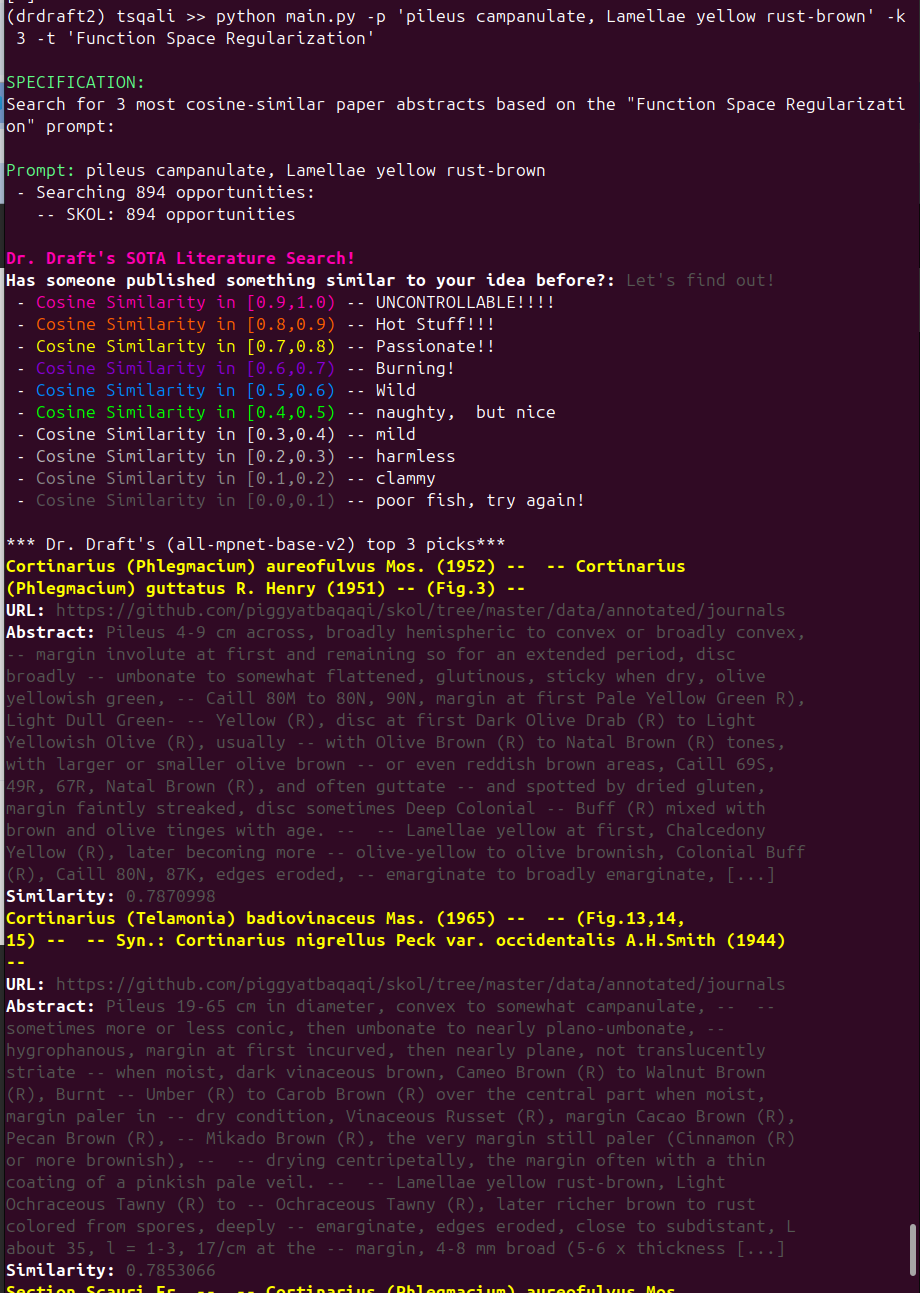

## Compute JSON versions of all descriptions

There is an anticipated need for the details of each description to be available as a nested JSON structure, which can be used to build menus with features, subfeatures, and values.

Here is an example JSON representation of a technical description as generated by ChatGPT 4.9.

```JSON
{
    "mycelium": {
        "location": "on substrate",
        "color": "medium orange-brown"
    },
    "hyphae": {
        "septate": true,
        "diameter_um": {
            "min": 3,
            "max": 4 
        },
        "surface": "distinctly and coarsely rough",
        "orientation": "parallel to long axis of substrate tissue cells",
        "branching": {
            "location": "on exterior",
            "pattern": "non-patterned network"
        }
    },
    "sporulation_units": {
        "origin": "enlarging tips of short branches",
        "color_progression": [
            "concolorous with surface mycelium",
            "dark orange-brown",
            "black-brown and opaque"
        ],
        "attachment": {
            "occasional": "attached to hypha",
            "typical": "broken loose or obscured by crowding and opacity"
        }
    }
}
```

The TaxaJSONTranslator reads taxa from the CouchDB and writes annotated taxa back out to CouchDB.

In [ ]:
from taxa_json_translator import TaxaJSONTranslator as TJT

class TaxaJSONTranslator(TJT):
    """
    Translates taxa descriptions to structured JSON using a fine-tuned Mistral model.

    This class is optimized for processing PySpark DataFrames created by
    TaxonExtractor.load_taxa(), adding a new column with JSON-formatted features.
    """


In [ ]:
spark.stop()
spark = make_spark_session()

translator = TaxaJSONTranslator(
    spark=spark,
    base_model_id="mistralai/Mistral-7B-Instruct-v0.3",
    max_length=2048,
    max_new_tokens=1024,
    device="cuda",
    load_in_4bit=True,
    use_auth_token=True,
    couchdb_url=couchdb_url,
    username=couchdb_username,
    password=couchdb_password
)

### Run the mistral model to generate JSON from each Taxon description.

In [ ]:
if generate_json:
    descriptions_df = translator.load_taxa(db_name=taxon_db_name).limit(100)

In [ ]:
if generate_json:
    descriptions_df.show()

In [ ]:
if generate_json:
    json_annotated_df = translator.translate_descriptions_batch(
        taxa_df=descriptions_df,
        batch_size=10,
        description_col="description",
        output_col="json_annotated"
    )

### Add the generated fields as a field on the objects generated by save_taxa.

In [ ]:
if generate_json:
    results_df = translator.save_taxa(json_annotated_df, db_name=json_taxon_db_name)
    
    results_df.groupBy("success").count().show(truncate=False)
    
    print("\nError messages:")
    results_df.filter("success = false").select("error_message").distinct().show(truncate=False)

Due to issues with the classifier producing poor description fields, the mistral model is producing empty JSON descriptions. This is an area for further debugging.

## Hierarchical clustering

We use Agglomerative Clustering to group the taxa into "clades" based in cosine similarity of their SBERT embeddings. We then load them into neo4j for exploration.

In [ ]:
from taxon_clusterer import TaxonClusterer as TC, ClusterNode
from scipy.cluster.hierarchy import linkage, to_tree

class TaxonClusterer(TC):
    pass


In [ ]:
if run_clustering:
    clusterer = TaxonClusterer(
        redis_host="localhost",
        redis_port=6379,
        redis_db=0,
        neo4j_uri=neo4j_uri,
    )
    
    # Load embeddings from Redis
    (embeddings, taxon_names, metadata) = clusterer.load_embeddings(embedding_name)

Here is an excellent description. The taxon name is kind of terrible, but I can imagine how the lines qualified as species name.

In [ ]:
(taxon_names[0], metadata[0])

In [ ]:
if run_clustering:
    # Perform clustering
    linkage_matrix = clusterer.cluster(method="average", metric="cosine")
    
    # Store in Neo4j with root named "Fungi"
    clusterer.store_in_neo4j(root_name="Fungi", clear_existing=True)
    
    print("✓ Clustering complete!")

### 3 related leaves

To demonstrate the effectiveness of clustering, here is a 3 leaf subtree (pseudoclade) with identical descriptions. If the classifier were working properly, there'd be a lot more description. The species names turned out well. The fragment of description they share shows through organisms that are characterized by features present when cultured on agar.

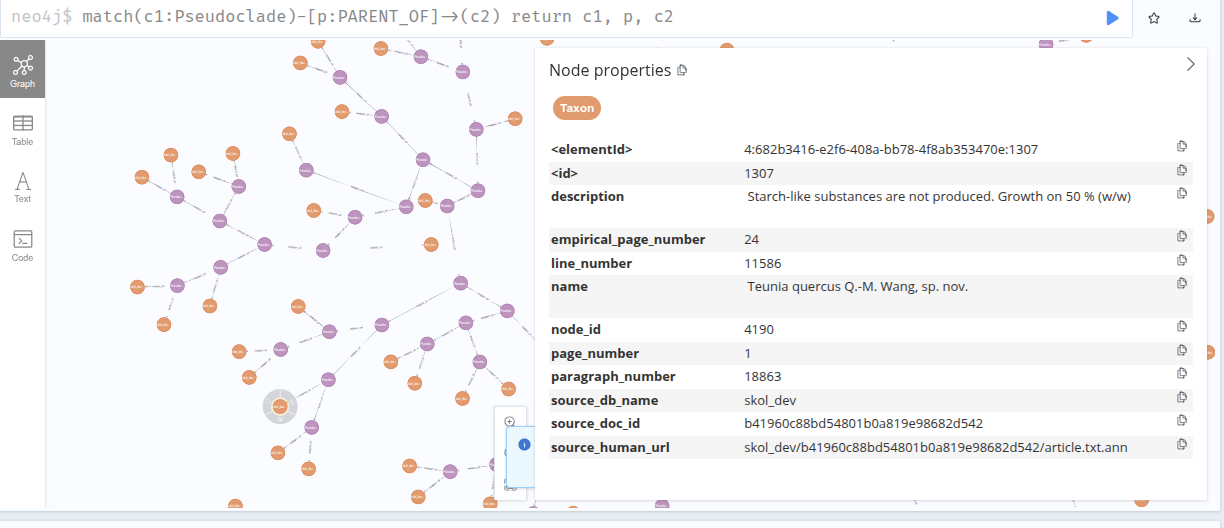
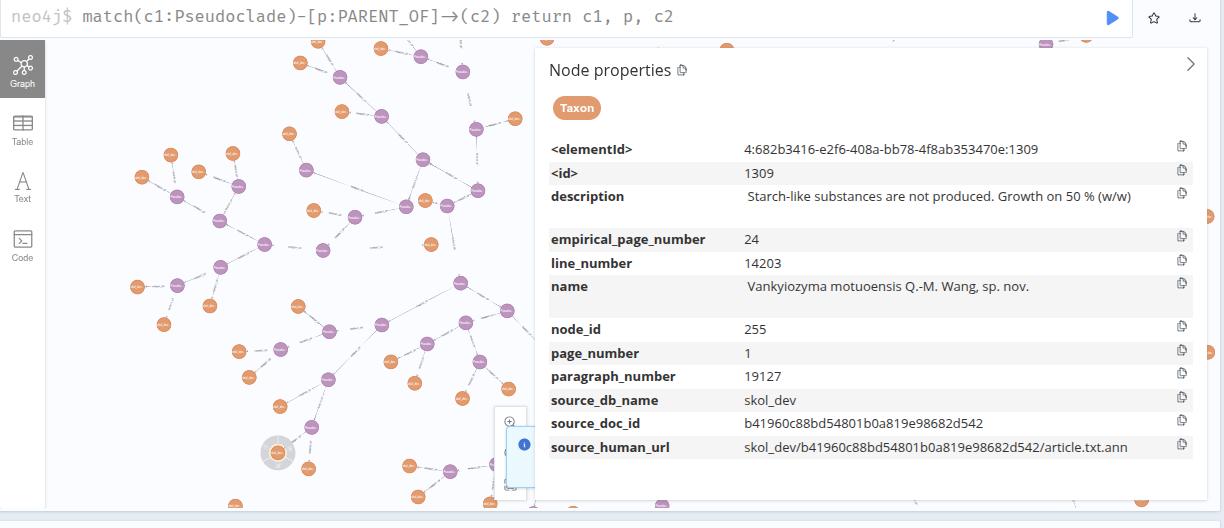
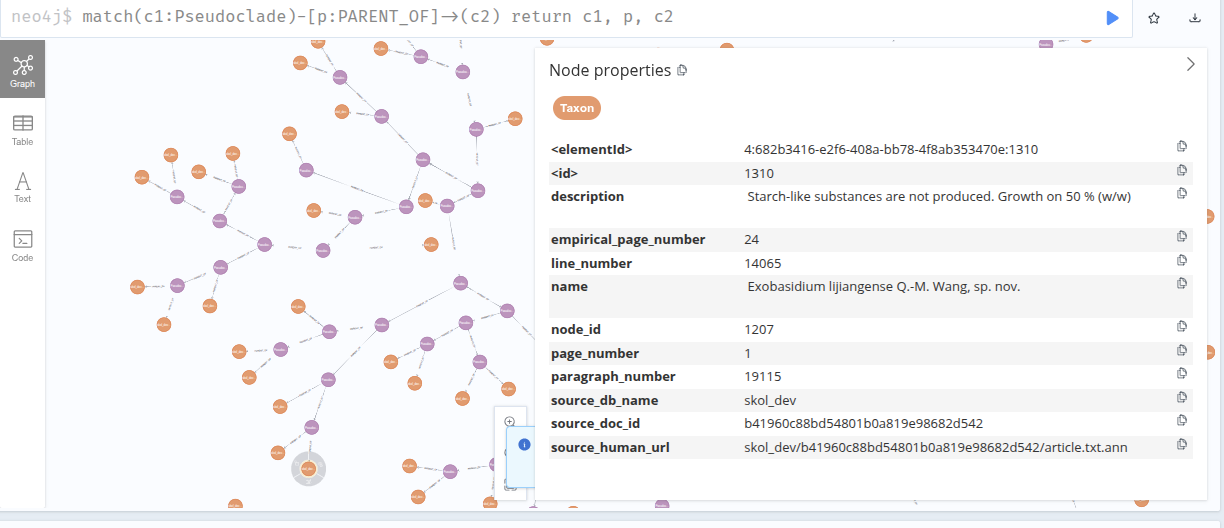

## Bibliography

* Anderson, J. Chris, Jan Lehnardt, and Noah Slater, 2010, "CouchDB: The Definitive Guide", O'Reilly Media.
* Balasi, Jen, Chris Murphy, Shintaro Osuga, La Monte Yarroll: “Synoptic Key of Life” PowerPoint presentation for IST 664, 2024, https://github.com/piggyatbaqaqi/skol/blob/master/docs/SKOL_presentation3.pptx, retrieved Feb 4, 2025.
* Caspers, Dave, Chris Murph, La Monte H.P. Yarroll, "Synoptic Key of Life II", https://docs.google.com/document/d/1SiuWlLmD_R4i8SNVr7WkTtjBwOdKDJqB/edit?usp=sharing&ouid=112079383051265085039&rtpof=true&sd=true, retrieved December 14, 2025.
* doi Foundation, "DOI Citation Formatter HTTP API", https://citation.doi.org/api-docs.html, accessed 2025-11-12.
* Eddelbuettel, D. (2022). A Brief Introduction to Redis (arXiv:2203.06559). arXiv. https://arxiv.org/abs/2203.06559 * Terrill, Gavin, (June 5, 2008). "Neo4j - an Embedded, Network Database". InfoQ. C4Media Inc. http://www.infoq.com/news/2008/06/neo4j Retrieved 2010-02-17.
* Gisolfi, Dr. Nick, "Dr Draft's state-of-the-art (SOTA) Literature Search", https://github.com/autonlab/dr-drafts-sota-literature-search, retrieved December 14, 2025.
* Hennebert, G.L., Richard P. Korf eds., Mycotaxon: A New Journal on Taxonomy and Nomenclature of Fungi and Lichens, Ithaca, NY., 1974-2010.
* Le, Patrick, Padmaja Kurumaddali, La Monte H.P. Yarroll. "Synoptic Key of Life: Feature Extraction for Fungal Taxonomy", https://docs.google.com/document/d/1m_Ja1YnyoA8zcAwI2XnKJOWBzgp8DCIX/edit?usp=sharing&ouid=112079383051265085039&rtpof=true&sd=true, retrieved December 14, 2025.
* Murrill, William A., Mycologia, New York Botanical Garden, Mycological Society of America, 1909-1961.
* Nauta, M.M., M.E. Noordeloos, eds., Persoonia: A Mycological Journal, Riksherbarium, Leiden, The Netherlands, 1959-1998.
* Yang, Jie and Zhang, Yue and Li, Linwei and Li, Xingxuan, 2018, "YEDDA: A Lightweight Collaborative Text Span Annotation Tool", Proceedings of the 56th Annual Meeting of the Association for Computational Linguistics, http://aclweb.org/anthology/P18-4006


## Source Code

The source code is in 2 projects on github: [SKOL](https://github.com/piggyatbaqaqi/skol) and [Dr Drafts Mycosearch](https://github.com/piggyatbaqaqi/dr-drafts-mycosearch).

The eventual home for SKOL is https://synoptickeyof.life.

## Appendix: On the use of an AI Coder

Portions of this work were completed with the aid of Claude Code Pro. I wish to give a clarifying example of how I've used this very powerful tool, and reveal why I am comfortable with claiming authorship of the resulting code.

For this project I needed results from an earlier class project in which a trio of students built and evaluated models for classifying paragraphs. The earlier work was built as a iPython Notebook, with many examples and inline code. Just copying the earlier notebook would have introduced many irrelevant details and would not further the overall project.

I asked Claude Code to translate the notebook into a module that I could import. It did a pretty good job. Without being told, it made a submodule, extracted the illustrative code as examples, wrote reasonable documentation, and created packaging for the module.

The skill level of the coding was roughly that of a highly disciplined average junior programmer. The architecture was simplistic and violated several design constraints such as DRY. I requested specific refactorings, such as asking for a group of functions to be converted into an object that shared duplicated parameters.

The initial code used REST interfaces directly, and read all the data into a single machine, not using pyspark correctly. Through a series of refactorings, I asked that the code use appropriate libraries I named, and create correct udf functions to execute transformations in parallel.

I walked the AI through creating an object that I could use to illustrate my use of redis and couchdb interfaces, while leaving the irrelevant details in a separate library.

In short, I still have to understand good design principles. I have to be able to recognize where appropriate libraries were applicable. I still have to understand the frameworks I am working with.

I now have a strong understanding of the difference between "vibe coding" and AI-assisted software engineering. In my first 4 hours with Claude Code, I was able to produce roughly 4 days' worth of professional-grade working code.

I'm still learning how to use Claude Code effectively for debugging. Feeding it a series of error messages leads to increasingly convoluted code. Using it to help produce a small test program which I can hand inspect seems to work better. I've had moderate success with "Run the test program and correct any errors.", especially where I'm willing to review each edit as it is produced.